# Spatial molecular niche discovery

Here we will use seqFISH Mouse Organogenesis datasets as an example to illustrate how Garfield performs spatial molecular niche discovery for multiple batches. Data access: https://marionilab.cruk.cam.ac.uk/SpatialMouseAtlas/.

In [1]:
import os
import pandas as pd
import numpy as np

os.chdir('/data2/zhouwg_data/project/Garfield')
os.getcwd()

'/data2/zhouwg_data/project/Garfield'

In [2]:
# load packages
import os
import warnings
import Garfield as gf
import scanpy as sc
from mudata import MuData
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

gf.__version__

'0.3.7'

In [3]:
# Load data
# Define paths
st_data_folder_path = "/home/zhouweige/zhouwg_data/project/Garfield_tutorials/data" # spatially resolved transcriptomics data
dataset = "seqfish_mouse_organogenesis"
cell_type_key = "celltype_mapped_refined"

adata_list = []
batch_indeces = list(np.arange(6) + 1)
batches = ["embryo1_z2",
           "embryo1_z5",
           "embryo2_z2",
           "embryo2_z5",
           "embryo3_z2",
           "embryo3_z5"]

for batch_idx, batch in zip(batch_indeces, batches):
    adata = sc.read_h5ad(f"{st_data_folder_path}/{dataset}_batch{batch_idx}.h5ad")
    adata.var_names_make_unique(join="++")
    # make spot name unique
    # adata.obs_names = [x+'_'+batch for x in adata.obs_names]
    adata_list.append(adata)

In [4]:
import anndata as ad

adata_concat = ad.concat(adata_list, label="slice_name", keys=batches)
adata_concat

AnnData object with n_obs × n_vars = 52568 × 351
    obs: 'Area', 'celltype_mapped_refined', 'sample', 'batch', 'slice_name'
    obsm: 'spatial'
    layers: 'counts'

In [5]:
# check the batch information of this dataset
adata_concat.obs['batch'].value_counts()

batch
embryo3_z2    11169
embryo1_z2    10150
embryo3_z5     9408
embryo2_z2     7661
embryo1_z5     7656
embryo2_z5     6524
Name: count, dtype: int64

In [6]:
# Ensure adata.X is counts.
adata_concat.X = adata_concat.layers['counts'].copy()
adata_concat.X.max()

141.0

### Integrating spatially resolved transcriptomics data using Garfield

For spatial niche discovery from spatially resolved transcriptomics data, we should adjust the following paremeters,
and all parameter introductions can be found in [Garfield_Model_Parameters](https://github.com/zhou-1314/Garfield/blob/main/Garfield_Model_Parameters.md).

In [7]:
# set workdir
workdir = '/home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_spRNA_embryo'
gf.settings.set_workdir(workdir)

### modify parameter
user_config = dict(
    ## Input options
    adata_list=adata_concat,
    profile='spatial',
    data_type='single-modal',
    sample_col='batch',
    weight=0.5,
    ## Preprocessing options
    graph_const_method='mu_std', # mu_std, Radius, KNN, Squidpy
    used_hvg=True,
    min_cells=3,
    min_features=0,
    keep_mt=False,
    target_sum=1e4,
    rna_n_top_features=3000,
    n_components=50,
    n_neighbors=5,
    metric='euclidean',
    svd_solver='arpack',
    # datasets
    used_pca_feat=False,
    adj_key='connectivities', 
    # data split parameters
    edge_val_ratio=0.1,
    edge_test_ratio=0.,
    node_val_ratio=0.1,
    node_test_ratio=0.,
    ## Model options
    augment_type='svd',
    svd_q=5,
    use_FCencoder=False,
    conv_type='GATv2Conv', # GAT or GATv2Conv or GCN
    gnn_layer=2,
    hidden_dims=[128, 128],
    bottle_neck_neurons=20,
    cluster_num=20,
    drop_feature_rate=0.2, 
    drop_edge_rate=0.2,
    num_heads=3,
    dropout=0.2,
    concat=True,
    used_edge_weight=True,
    used_DSBN=False,
    used_mmd=False,
    # data loader parameters
    num_neighbors=5,
    loaders_n_hops=2,
    edge_batch_size=4096,
    node_batch_size=128, # None
    # loss parameters
    include_edge_recon_loss=True,
    include_gene_expr_recon_loss=True,
    lambda_latent_contrastive_instanceloss=1.0,
    lambda_latent_contrastive_clusterloss=0.5,
    lambda_gene_expr_recon=5., 
    lambda_edge_recon=5., #
    lambda_latent_adj_recon_loss=1.0,
    lambda_omics_recon_mmd_loss=0.2,
    # train parameters
    n_epochs_no_edge_recon=0,
    learning_rate=0.001,
    weight_decay=1e-05,
    gradient_clipping=5,
    # other parameters
    latent_key='garfield_latent',
    reload_best_model=True,
    use_early_stopping=True,
    early_stopping_kwargs=None,
    monitor=True,
    device_id=1,
    seed=2024,
    verbose=True
)
dict_config = gf.settings.set_gf_params(user_config)

Saving results in: /home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_spRNA_embryo


In [8]:
from Garfield.model import Garfield

# Initialize model
model = Garfield(dict_config)

--- DATA LOADING AND PREPROCESSING ---
------Calculating spatial graph...
COSINE SIM GRAPH DECODER -> dropout_rate: 0.2


In [9]:
# Train model
model.train()


--- INITIALIZING TRAINER ---
Number of training nodes: 47311
Number of validation nodes: 5257
Number of training edges: 272406
Number of validation edges: 30267
Edge batch size: 4096
Node batch size: 128

--- MODEL TRAINING ---
Epoch 1/100 |--------------------| 1.0% val_auroc_score: 0.8599; val_auprc_score: 0.8641; val_best_acc_score: 0.7902; val_best_f1_score: 0.7922; train_kl_reg_loss: 106.7204; train_edge_recon_loss: 5701.3448; train_gene_expr_recon_loss: 330401.4109; train_lambda_latent_adj_recon_loss: 2374.0288; train_lambda_latent_contrastive_instanceloss: 7.0498; train_lambda_latent_contrastive_clusterloss: 3.6256; train_global_loss: 338594.1814; train_optim_loss: 338594.1814; val_kl_reg_loss: 85.1359; val_edge_recon_loss: 5049.8654; val_gene_expr_recon_loss: 287494.0391; val_lambda_latent_adj_recon_loss: 2153.6537; val_lambda_latent_contrastive_instanceloss: 6.4610; val_lambda_latent_contrastive_clusterloss: 3.3526; val_global_loss: 294792.5039; val_optim_loss: 294792.5039
Ep

In [10]:
# Compute latent neighbor graph
latent_key = 'garfield_latent'
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)
# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [11]:
# Compute latent Leiden clustering
latent_leiden_resolution = 1.2
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
latent_key = "garfield_latent"

sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)
len(model.adata.obs[latent_cluster_key].unique())

23

### Visualize Garfield Latent Space

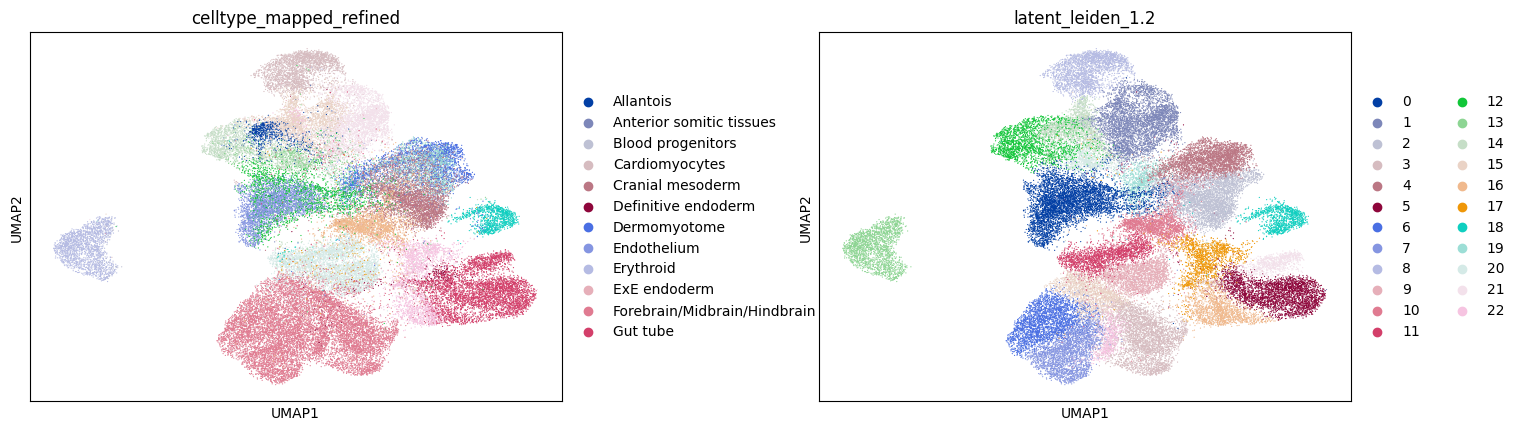

In [12]:
sc.pl.umap(model.adata, color=['celltype_mapped_refined', latent_cluster_key], show=True, wspace=0.35, size=3)

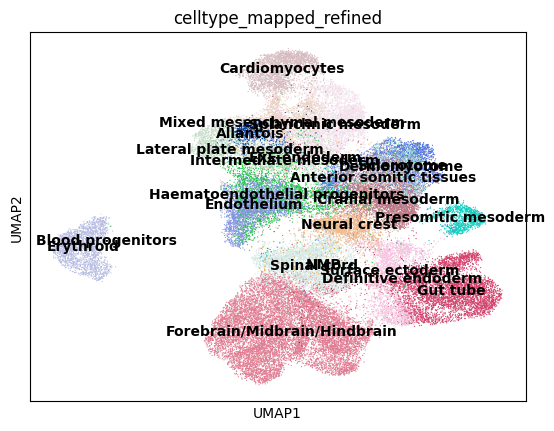

In [13]:
## celltype
sc.pl.umap(model.adata, color=[ 'celltype_mapped_refined'], ncols=3,
           wspace=0.5, show=True, legend_loc='on data', size=3)

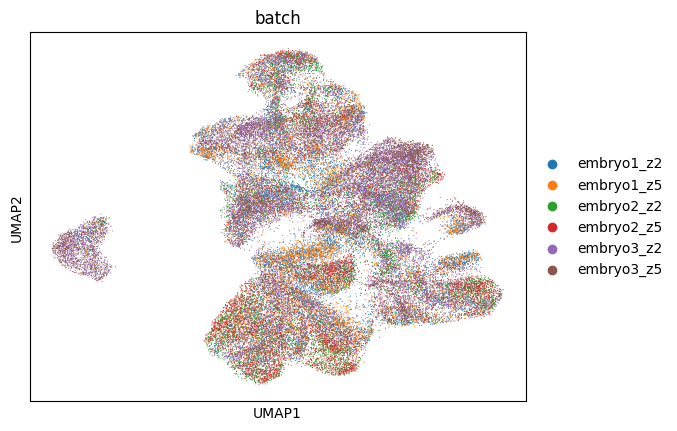

In [14]:
## batch information
sc.pl.umap(model.adata, color=['batch'], show=True)

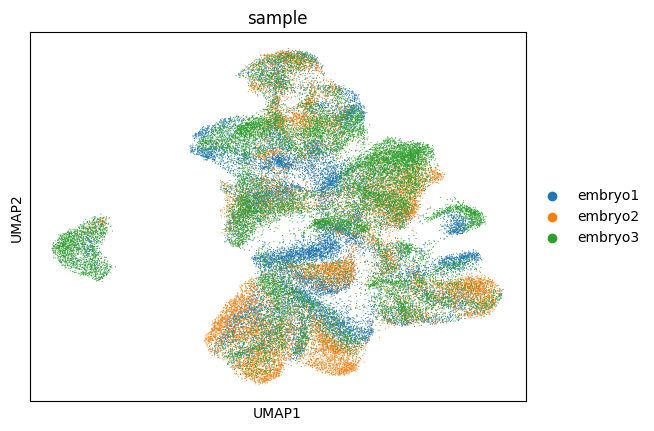

In [15]:
## sample information
sc.pl.umap(model.adata, color=['sample'], ncols=3,
           wspace=0.5, show=True)

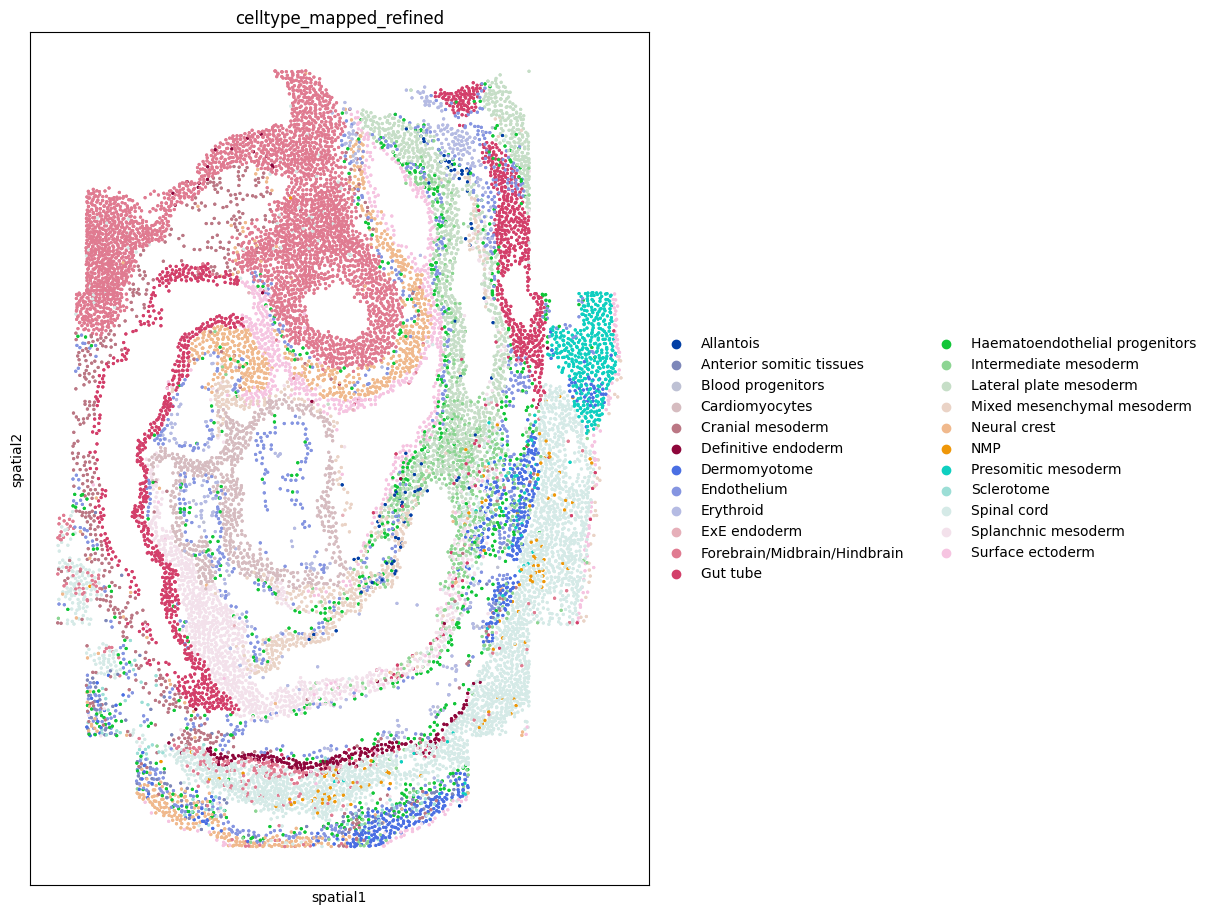

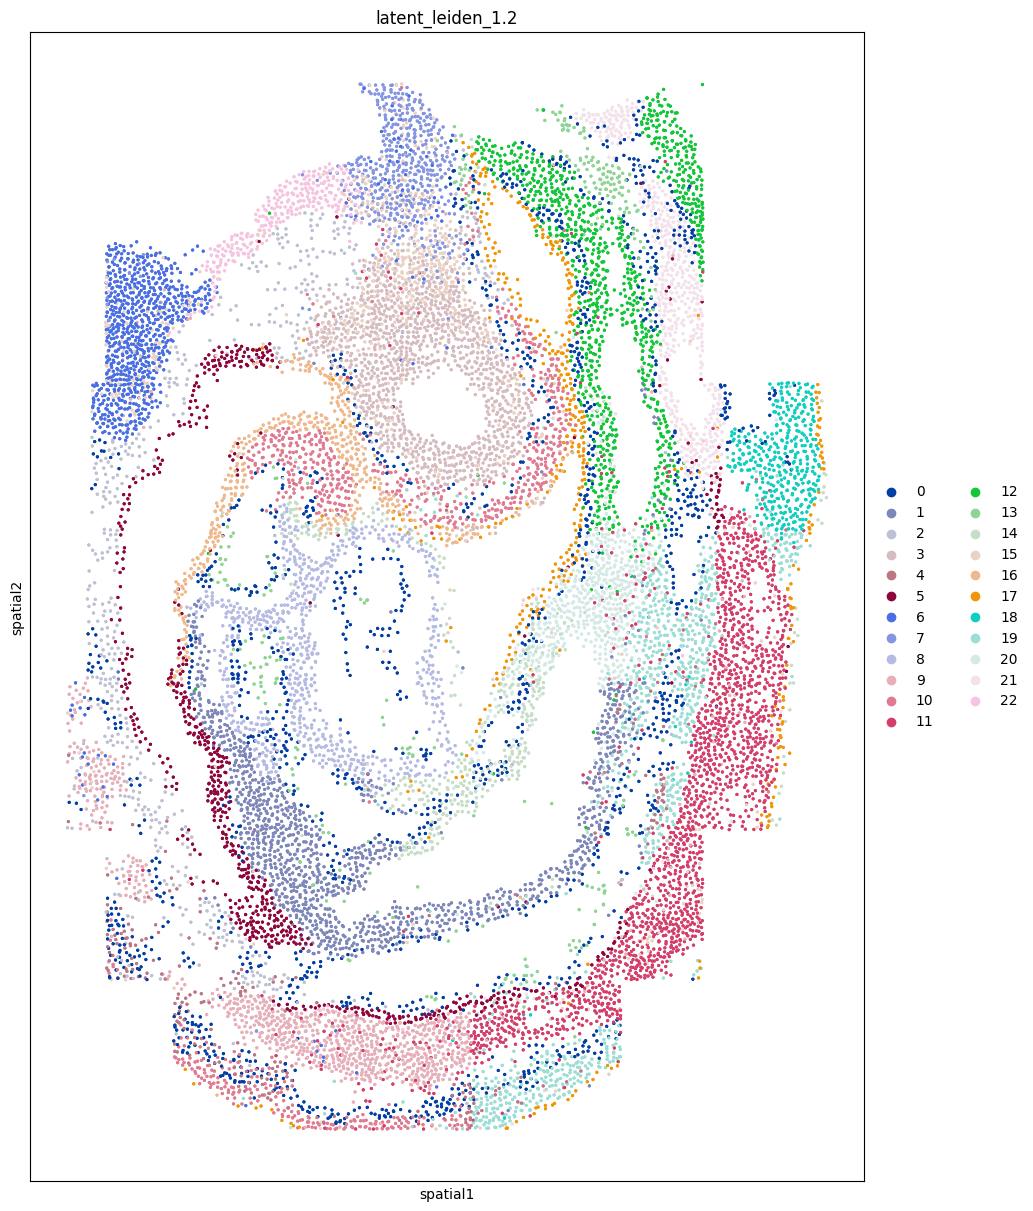

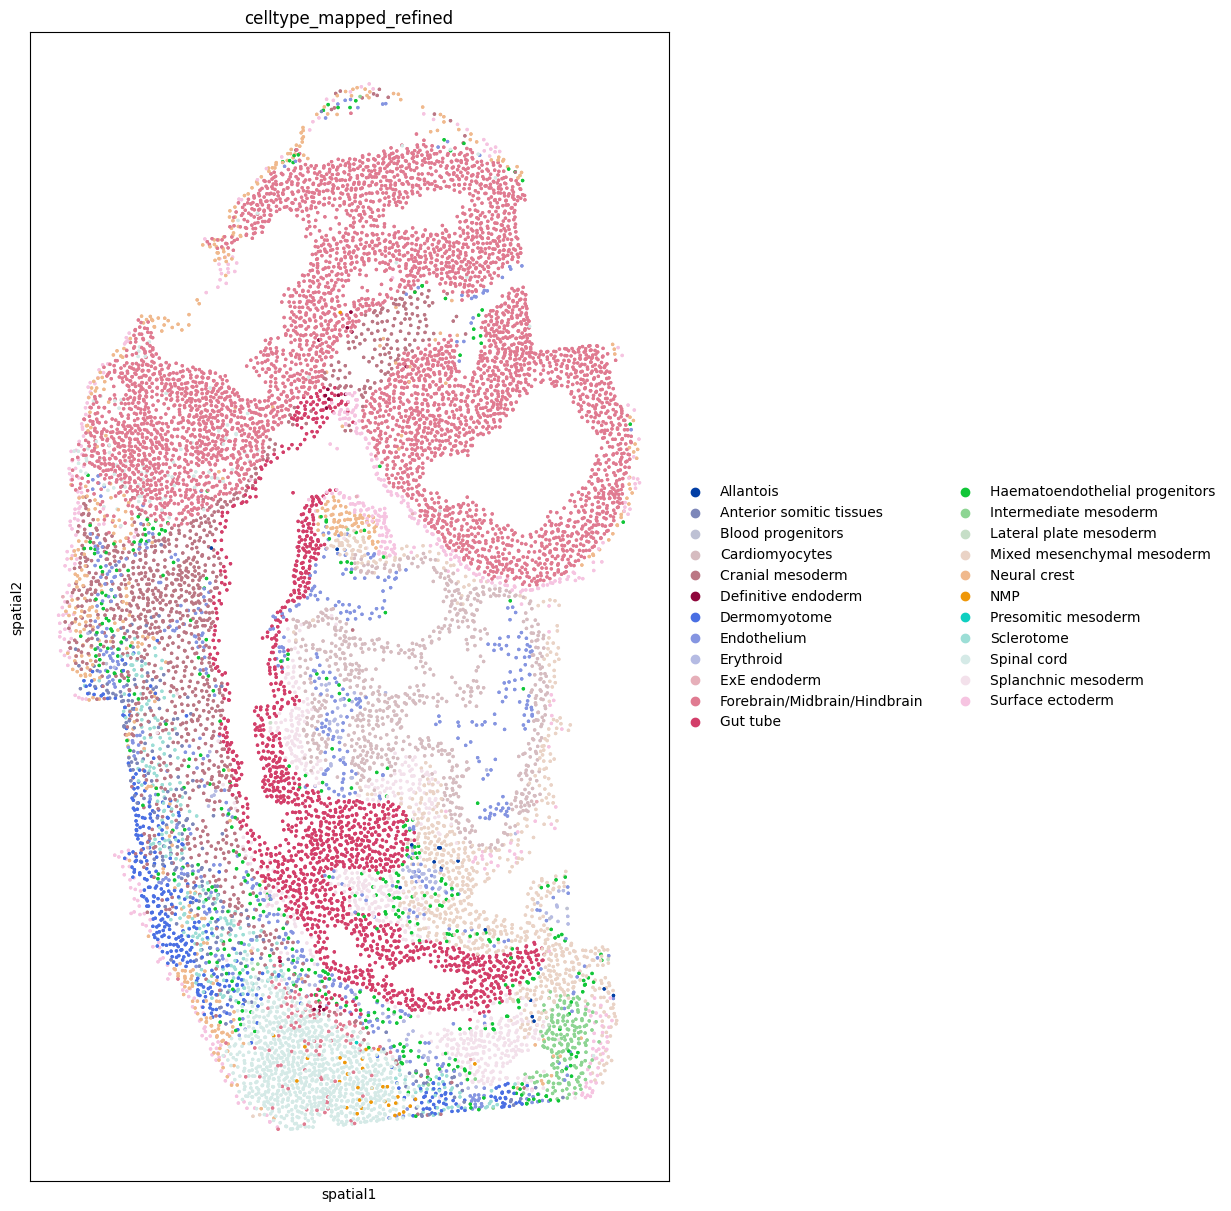

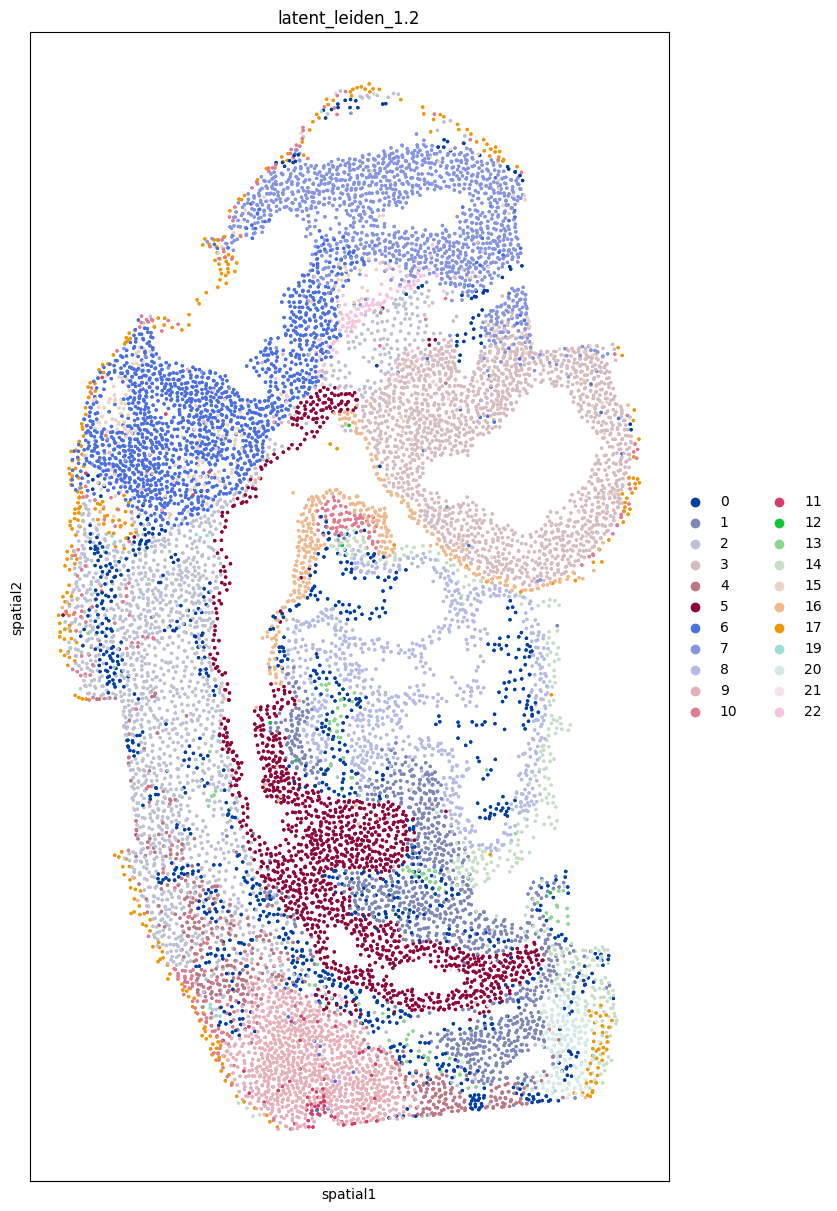

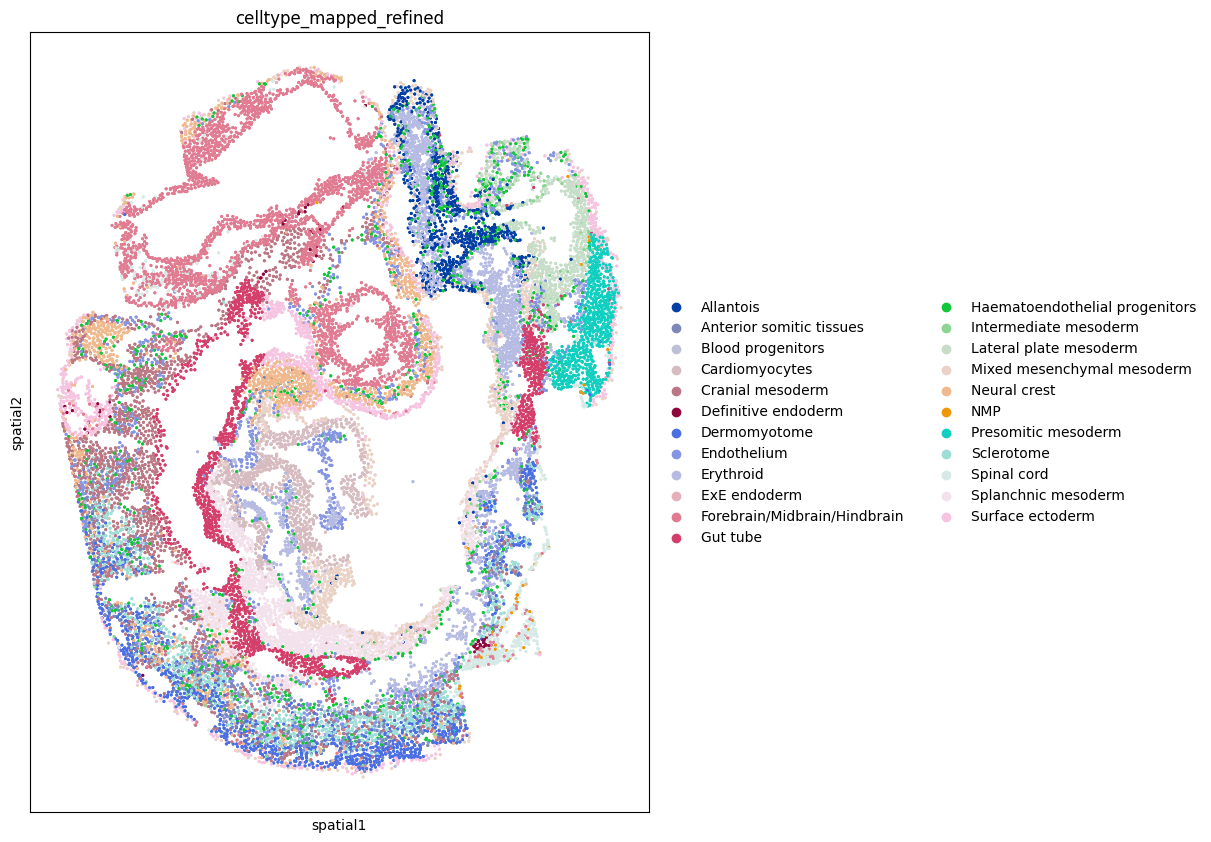

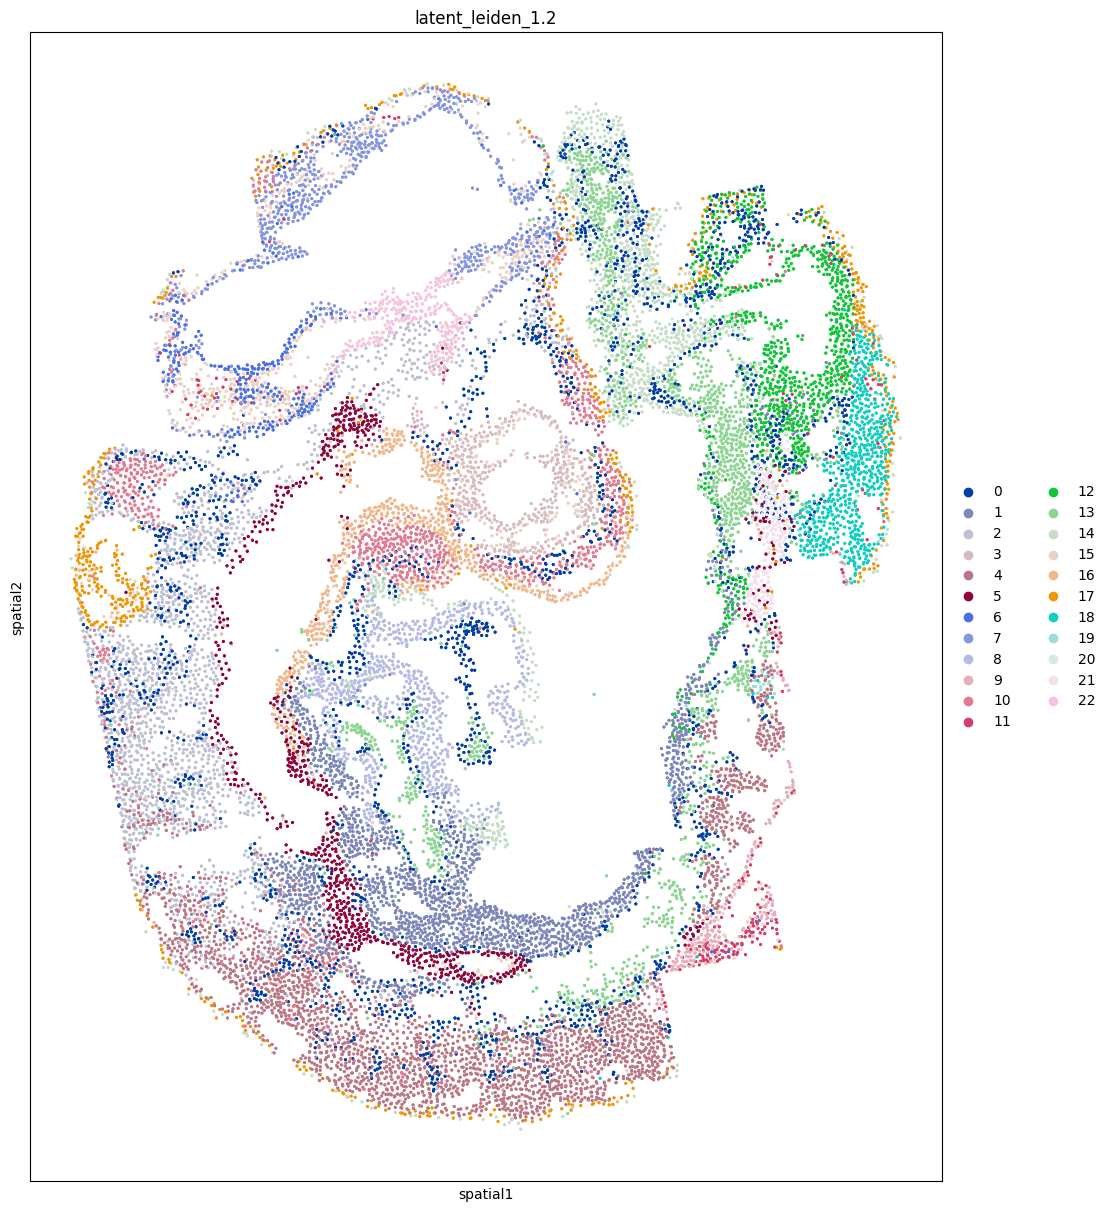

In [16]:
### Display spatial location distribution by sample
import squidpy as sq

batch_indeces = list(model.adata.obs['sample'].unique())
for batch_idx in batch_indeces:
    tmp = model.adata[model.adata.obs['sample'] == batch_idx, ]

    # Visualize cell-level annotated data in physical space
    sq.pl.spatial_scatter(tmp, color=cell_type_key, shape=None, figsize=(12, 12))
    sq.pl.spatial_scatter(tmp, color=latent_cluster_key, shape=None, figsize=(12, 12))

In [17]:
# Save trained model
model_folder_path = f"{workdir}/model"
os.makedirs(model_folder_path, exist_ok=True)

model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata_ref.h5ad")

Model saved successfully using pickle at /home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_spRNA_embryo/model/attr.pkl
